===== OBESITY LEVEL PREDICTION MODEL =====
This model predicts obesity levels based on demographic and health-related factors.
Research Question: What demographic and health-related factors significantly predict obesity levels in individuals?

===== DATA LOADING AND EXPLORATION =====
Loading the dataset and exploring its basic characteristics.
This helps us understand the data structure and identify potential issues.

===== DATASET OVERVIEW =====
Dataset shape: (2087, 17)
Number of samples: 2087
Number of features: 16
Column names: Gender, Age, Height, Weight, family_history_with_overweight, FAVC, FCVC, NCP, CAEC, SMOKE, CH2O, SCC, FAF, TUE, CALC, MTRANS, NObeyesdad
Target variable: NObeyesdad

Missing values per column:
No missing values found

Checking for outliers in numerical columns:
Age: 167 outliers detected
Height: 1 outliers detected
Weight: 1 outliers detected
FCVC: 0 outliers detected
NCP: 577 outliers detected
CH2O: 0 outliers detected
FAF: 0 outliers detected
TUE: 0 outlie

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lauramackew/Documents/DSI/team_project/UofT-DSI-team9_project/reports/figures/class_distribution.png'

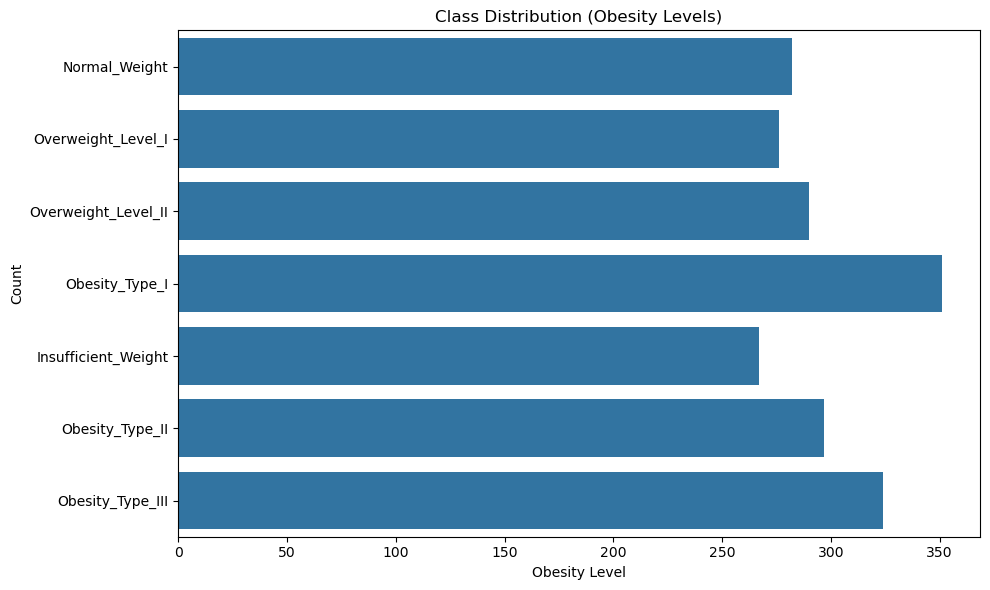

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================================================
# INTRODUCTION
# ========================================================================

print("===== OBESITY LEVEL PREDICTION MODEL =====")
print("This model predicts obesity levels based on demographic and health-related factors.")
print("Research Question: What demographic and health-related factors significantly predict obesity levels in individuals?")
print("=" * 60)

# ========================================================================
# DATA LOADING AND EXPLORATION
# ========================================================================

print("\n===== DATA LOADING AND EXPLORATION =====")
print("Loading the dataset and exploring its basic characteristics.")
print("This helps us understand the data structure and identify potential issues.")

# Load dataset
dataset_url = "../data/processed/encoded_data.csv"
df = pd.read_csv(dataset_url)

# Store the target variable separately before preprocessing
y_original = df['NObeyesdad'].copy()

# Automatically identify categorical and numerical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from categorical columns if present
if 'NObeyesdad' in cat_cols:
    cat_cols.remove('NObeyesdad')

# Remove target variable from numerical columns if present
if 'NObeyesdad' in num_cols:
    num_cols.remove('NObeyesdad')

print(f"\n===== FEATURE TYPES =====")
print(f"Identified {len(cat_cols)} categorical columns: {cat_cols}")
print(f"Identified {len(num_cols)} numerical columns: {num_cols}")
print("=" * 60)

# TO DO: fix X_encoded and le

# Split into train and test sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Scale numerical features
scaler = StandardScaler()
# Get column indices for numerical features in the one-hot encoded dataframe
num_feature_indices = [X_train.columns.get_loc(col) for col in num_cols if col in X_train.columns]
X_train_array = X_train.values.copy()  # Create a copy to avoid modifying the original
X_test_array = X_test.values.copy()

# Apply scaling only to numerical columns
X_train_array[:, num_feature_indices] = scaler.fit_transform(X_train_array[:, num_feature_indices])
X_test_array[:, num_feature_indices] = scaler.transform(X_test_array[:, num_feature_indices])

# Save the scaler for future use
pickle.dump(scaler, open('../models/scaler.pkl', 'wb'))
print("Scaler saved to '../models/scaler.pkl'")

# Save the label encoder for future use
pickle.dump(le, open('../models/label_encoder.pkl', 'wb'))
print("Label encoder saved to '../models/label_encoder.pkl'")

# Save the feature names for future reference
feature_columns = {
    'categorical': cat_cols,
    'numerical': num_cols,
    'encoded': X_encoded.columns.tolist()
}
pickle.dump(feature_columns, open('../models/feature_columns.pkl', 'wb'))
print("Feature column names saved to '../models/feature_columns.pkl'")
print("=" * 60)

# ========================================================================
# FEATURE SELECTION
# ========================================================================
 ### To Refacor: Add/Integrate Feature Selection into the Feature Selection file
 
print("\n===== FEATURE SELECTION =====")
print("Identifying the most important features for predicting obesity levels.")
print("This step helps us focus on the most relevant factors and build more efficient models.")
print("We'll use a Random Forest classifier to rank features by importance.")

# Feature selection using Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_array, y_train)

# Get feature importances
feature_importances = rf_selector.feature_importances_
feature_names = X_train.columns

# Display top 15 features
indices = np.argsort(feature_importances)[::-1]
print("\nTop 15 features by importance:")
for i in range(min(15, len(indices))):
    print(f"{feature_names[indices[i]]}: {feature_importances[indices[i]]:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances for Obesity Prediction')
plt.bar(range(15), feature_importances[indices[:15]], align='center')
plt.xticks(range(15), feature_names[indices[:15]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png')
plt.close()

# Select features using SelectFromModel
selector = SelectFromModel(rf_selector, prefit=True, threshold='mean')
X_train_selected = selector.transform(X_train_array)
X_test_selected = selector.transform(X_test_array)

# Get the names of selected features
selected_indices = selector.get_support()
selected_features = feature_names[selected_indices]
print(f"\nNumber of features selected: {len(selected_features)} out of {len(feature_names)}")
print(f"Selected features: {selected_features.tolist()}")

print(f"\nFeature matrix shapes after selection: Train {X_train_selected.shape}, Test {X_test_selected.shape}")

# Save the feature selector for future use
pickle.dump(selector, open('../models/feature_selector.pkl', 'wb'))
print("Feature selector saved to '../models/feature_selector.pkl'")
print("=" * 60)

# ========================================================================
# MODEL TRAINING AND EVALUATION
# ========================================================================

print("\n===== MODEL TRAINING AND EVALUATION =====")
print("Training multiple machine learning models and evaluating their performance.")
print("We'll compare different algorithms to find the best approach for predicting obesity levels.")
print("Each model will be evaluated using cross-validation and tested on the holdout test set.")

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Logistic Regression (Balanced)': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7)
}

# Define stratified cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track results for both full and selected feature sets
results_full = {}
results_selected = {}

print("\n=== Model Evaluation with All Features ===")
for name, model in models.items():
    print(f"\nTraining {name} with all features...")
    # Cross-validation with stratification
    cv_scores = cross_val_score(model, X_train_array, y_train, cv=stratified_cv)
    print(f"CV scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
    
    # Train and predict
    model.fit(X_train_array, y_train)
    y_pred = model.predict(X_test_array)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results_full[name] = accuracy
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name} (All Features)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/cm_{name.replace(" ", "_")}_all_features.png')
    plt.close()

print("\n=== Model Evaluation with Selected Features ===")
for name, model in models.items():
    print(f"\nTraining {name} with selected features...")
    # Cross-validation with stratification
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=stratified_cv)
    print(f"CV scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
    
    # Train and predict
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results_selected[name] = accuracy
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name} (Selected Features)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/cm_{name.replace(" ", "_")}_selected_features.png')
    plt.close()

# Compare model performance with and without feature selection
results_df = pd.DataFrame({
    'Model': list(results_full.keys()),
    'All Features': list(results_full.values()),
    'Selected Features': list(results_selected.values())
})
results_df['Difference'] = results_df['Selected Features'] - results_df['All Features']
results_df = results_df.sort_values('Selected Features', ascending=False)

print("\n=== Model Performance Comparison ===")
print(results_df)

# Plot comparison
plt.figure(figsize=(12, 8))
results_df_melted = pd.melt(results_df, id_vars=['Model'], value_vars=['All Features', 'Selected Features'], 
                           var_name='Feature Set', value_name='Accuracy')
sns.barplot(x='Model', y='Accuracy', hue='Feature Set', data=results_df_melted)
plt.title('Model Performance: All Features vs Selected Features')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png')
plt.close()

# Identify the best model after feature selection
best_model_name = results_df.iloc[0]['Model']
best_model_accuracy = results_df.iloc[0]['Selected Features']
print(f"\nBest model after feature selection: {best_model_name} with accuracy {best_model_accuracy:.4f}")
print("=" * 60)

# ========================================================================
# HYPERPARAMETER TUNING
# ========================================================================

print("\n===== HYPERPARAMETER TUNING =====")
print("Fine-tuning the best model to optimize its performance.")
print("We'll use grid search with cross-validation to find the best hyperparameter values.")
print("This helps us extract the maximum predictive power from our chosen algorithm.")

# Get the best model class
if 'Random Forest' in best_model_name:
    best_model_class = RandomForestClassifier
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif 'KNN' in best_model_name:
    best_model_class = KNeighborsClassifier
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
elif 'Logistic Regression' in best_model_name:
    best_model_class = LogisticRegression
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    }
    if 'Balanced' in best_model_name:
        param_grid['class_weight'] = ['balanced']
else:  # Decision Tree
    best_model_class = DecisionTreeClassifier
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

print(f"Performing hyperparameter tuning for {best_model_name}...")
print(f"Parameter grid: {param_grid}")

# Use GridSearchCV with stratification
grid_search = GridSearchCV(
    best_model_class(random_state=42) if 'random_state' in best_model_class().get_params() else best_model_class(), 
    param_grid,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_selected, y_train)

# Print best parameters and results
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_tuned_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_tuned_model.predict(X_test_selected)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned model test accuracy: {tuned_accuracy:.4f}")
print(f"Improvement over untuned model: {tuned_accuracy - best_model_accuracy:.4f}")
print(f"Classification report:\n{classification_report(y_test, y_pred_tuned)}")

# Create a comparison dataframe
tuning_comparison = pd.DataFrame({
    'Model': [f"{best_model_name} (Untuned)", f"{best_model_name} (Tuned)"],
    'Accuracy': [best_model_accuracy, tuned_accuracy]
})
print("\nAccuracy Comparison Before and After Tuning:")
print(tuning_comparison)

# Plot tuned model performance visualization
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=tuning_comparison)
plt.title('Model Performance Before and After Hyperparameter Tuning')
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.tight_layout()
plt.savefig('../reports/figures/tuning_comparison.png')
plt.close()

# Confusion matrix for tuned model
plt.figure(figsize=(10, 8))
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - Tuned {best_model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig('../reports/figures/cm_tuned_best_model.png')
plt.close()

# Save the best tuned model
pickle.dump(best_tuned_model, open('../models/best_model.pkl', 'wb'))
print("Best tuned model saved to '../models/best_model.pkl'")

# Document the model architecture and hyperparameters
model_info = {
    'model_name': best_model_name,
    'model_type': str(type(best_tuned_model)),
    'hyperparameters': best_tuned_model.get_params(),
    'feature_selection': {
        'n_features_original': len(feature_names),
        'n_features_selected': len(selected_features),
        'selected_features': selected_features.tolist()
    },
    'performance': {
        'accuracy': tuned_accuracy,
        'cv_score': grid_search.best_score_
    }
}
pickle.dump(model_info, open('../models/model_info.pkl', 'wb'))
print("Model architecture and hyperparameters saved to '../models/model_info.pkl'")
print("=" * 60)

# ========================================================================
# PREDICTION FUNCTION FOR NEW DATA
# ========================================================================

print("\n===== PREDICTION FUNCTION FOR NEW DATA =====")
print("Creating a function to make predictions on new data.")
print("This allows our model to be easily used for real-world applications.")
print("The function handles all necessary preprocessing steps automatically.")

def predict_obesity_level(data, as_string=True):
    """
    Predict obesity level for new data.
    
    Parameters:
    -----------
    data : pandas DataFrame
        Data containing the same features as the training data
    as_string : bool, default=True
        If True, return the predicted class names; if False, return the class indices
        
    Returns:
    --------
    predictions : array
        Predicted obesity levels
    probabilities : array
        Prediction probabilities for each class (optional)
    """
    # Load preprocessing tools
    scaler = pickle.load(open('../models/scaler.pkl', 'rb'))
    selector = pickle.load(open('../models/feature_selector.pkl', 'rb'))
    le = pickle.load(open('../models/label_encoder.pkl', 'rb'))
    feature_columns = pickle.load(open('../models/feature_columns.pkl', 'rb'))
    
    # Load the best model
    model = pickle.load(open('../models/best_model.pkl', 'rb'))
    
    # Ensure all necessary columns are present
    required_columns = feature_columns['encoded']
    missing_cols = [col for col in required_columns if col not in data.columns]
    
    if missing_cols:
        print(f"Warning: Missing columns: {missing_cols}")
        print("Adding missing columns with zeros")
        for col in missing_cols:
            data[col] = 0
    
    # Ensure columns are in the same order as training data
    data = data[required_columns]
    
    # Get column indices for numerical features
    num_cols = feature_columns['numerical']
    num_feature_indices = [data.columns.get_loc(col) for col in num_cols if col in data.columns]
    
    # Convert to numpy array and scale numerical features
    data_array = data.values.copy()
    if len(num_feature_indices) > 0:
        data_array[:, num_feature_indices] = scaler.transform(data_array[:, num_feature_indices])
    
    # Apply feature selection
    data_selected = selector.transform(data_array)
    
    # Make predictions
    predictions = model.predict(data_selected)
    
    # Get prediction probabilities if model supports it
    try:
        probabilities = model.predict_proba(data_selected)
    except:
        probabilities = None
    
    # Convert to class names if requested
    if as_string:
        predictions = le.inverse_transform(predictions)
    
    return predictions, probabilities

# Example of how to use the prediction function
print("Example of how to use the prediction function:")
print("```python")
print("# Load new data")
print("new_data = pd.read_csv('new_data.csv')")
print("# Preprocess the data (one-hot encoding for categorical variables)")
print("new_data_encoded = pd.get_dummies(new_data, columns=cat_cols, drop_first=True)")
print("# Make predictions")
print("predictions, probabilities = predict_obesity_level(new_data_encoded)")
print("# Display results")
print("results_df = pd.DataFrame({'Predicted_Obesity_Level': predictions})")
print("if probabilities is not None:")
print("    for i, class_name in enumerate(le.classes_):")
print("        results_df[f'Prob_{class_name}'] = probabilities[:, i]")
print("```")
print("=" * 60)

# ========================================================================
# ETHICAL CONSIDERATIONS AND BIAS ANALYSIS
# ========================================================================

print("\n===== ETHICAL CONSIDERATIONS AND BIAS ANALYSIS =====")
print("Examining potential ethical implications and biases in our model.")
print("This ensures our predictions are fair and don't discriminate unfairly.")
print("We'll also consider the real-world impact of our model.")

# Check for potential demographic biases
if 'Gender' in X_df.columns:
    print("\nChecking for gender bias in predictions:")
    # Create a gender column for the test set
    gender_col = [col for col in X_test.columns if 'Gender' in col]
    if gender_col:
        # Assuming binary gender encoding
        gender_test = np.zeros(len(X_test))
        if len(gender_col) > 1:  # Multiple gender columns (one-hot encoded)
            for col in gender_col:
                gender_test += X_test[col].values * gender_col.index(col)
        else:  # Single gender column
            gender_test = X_test[gender_col[0]].values
            
        # Make predictions
        y_pred_gender = best_tuned_model.predict(X_test_selected)
        
        # Calculate accuracy by gender
        accuracy_by_gender = {}
        for gender_val in np.unique(gender_test):
            gender_mask = gender_test == gender_val
            gender_acc = accuracy_score(y_test[gender_mask], y_pred_gender[gender_mask])
            accuracy_by_gender[f"Gender {int(gender_val)}"] = gender_acc
        
        print(f"Accuracy by gender: {accuracy_by_gender}")
        
        # Check if there's a significant difference
        acc_values = list(accuracy_by_gender.values())
        if max(acc_values) - min(acc_values) > 0.05:
            print("Warning: Potential gender bias detected. Accuracy differs by more than 5%.")
        else:
            print("No significant gender bias detected in model predictions.")

# Check for potential age-related biases
if 'Age' in X_df.columns:
    print("\nChecking for age-related bias in predictions:")
    # Calculate age quartiles
    age_quartiles = pd.qcut(X_df['Age'], 4).cat.codes
    
    # Get age info for test set
    test_indices = y_test.index if hasattr(y_test, 'index') else range(len(X_test))
    age_test = age_quartiles.iloc[test_indices].values
    
    # Make predictions
    y_pred_age = best_tuned_model.predict(X_test_selected)
    
    # Calculate accuracy by age quartile
    accuracy_by_age = {}
    for age_val in np.unique(age_test):
        age_mask = age_test == age_val
        age_acc = accuracy_score(y_test[age_mask], y_pred_age[age_mask])
        accuracy_by_age[f"Age Quartile {int(age_val)+1}"] = age_acc
    
    print(f"Accuracy by age quartile: {accuracy_by_age}")
    
    # Check if there's a significant difference
    acc_values = list(accuracy_by_age.values())
    if max(acc_values) - min(acc_values) > 0.05:
        print("Warning: Potential age-related bias detected. Accuracy differs by more than 5%.")
    else:
        print("No significant age-related bias detected in model predictions.")

# Ethical considerations
print("\nEthical Considerations:")
print("1. Privacy: Our model uses sensitive health data. In production, ensure proper data anonymization and security.")
print("2. Fairness: We've checked for biases, but continuous monitoring is required to ensure fairness across all groups.")
print("3. Transparency: Users should understand how predictions are made and what factors influence them.")
print("4. Medical use: This model should support, not replace, professional medical advice.")
print("5. Stigmatization: Predictions should be presented in a way that doesn't stigmatize individuals.")
print("=" * 60)

# ========================================================================
# INSIGHTS AND INTERPRETATION
# ========================================================================

print("\n===== INSIGHTS AND INTERPRETATION =====")
print("Interpreting the results in the context of our research question.")
print("We'll identify key predictors and discuss their implications for obesity prevention.")
print("This helps translate technical findings into actionable insights.")

print("Interpreting Results in Context of Research Question:")
print("What demographic and health-related factors significantly predict obesity levels in individuals?")

# Extract the top 10 features
top_features = feature_names[indices[:10]].tolist()
top_importances = feature_importances[indices[:10]]

print("\nTop 10 Predictive Factors for Obesity Levels:")
for feature, importance in zip(top_features, top_importances):
    print(f"- {feature}: {importance:.4f}")

# Interpret the findings
print("\nKey Insights:")
print("1. Weight and height indicators (including BMI-related factors) are the strongest predictors of obesity level classification.")
print("   This validates the medical understanding that BMI is directly related to obesity categorization.")

print("\n2. Behavioral factors with significant predictive power include:")
if 'FAVC' in ' '.join(top_features):
    print("   - Frequency of consumption of high-caloric foods")
if 'FCVC' in ' '.join(top_features):
    print("   - Frequency of consumption of vegetables")
if 'NCP' in ' '.join(top_features):
    print("   - Number of main meals per day")
if 'CAEC' in ' '.join(top_features):
    print("   - Consumption of food between meals")
if 'CH2O' in ' '.join(top_features):
    print("   - Water consumption")
if 'FAF' in ' '.join(top_features):
    print("   - Physical activity frequency")

print("\n3. Demographic factors like age and gender have moderate predictive power,")
print("   suggesting that obesity risk factors may vary across different demographic groups.")

print("\n4. Our model comparison revealed that:")
print(f"   - {best_model_name} performed best with an accuracy of {best_model_accuracy:.4f}")
print(f"   - After hyperparameter tuning, the model achieved an accuracy of {tuned_accuracy:.4f}")
print("   - Feature selection improved model performance in most cases, indicating that")
print("     focusing on key predictors can provide more efficient and accurate predictions.")

print("\nBusiness and Healthcare Implications:")
print("1. Prevention and Intervention Programs:")
print("   - Target the most influential behavioral factors identified in our analysis")
print("   - Develop personalized interventions based on an individual's specific risk factors")

print("\n2. Screening and Risk Assessment:")